# Monitoring with alibi_detect

If needed install:

In [ ]:
!pip install matplotlib~=3.9.2 seaborn~=0.13.2 numpy==1.23.5

## Introduction

Illustrating the need to monitor metrics at various window sizes to catch performance degradation as soon as possible.

Imagine we are logging/saving the F1 metrics every day fo 35 days. To mimic this, we will output random numbers in predefined intervals for every hour of the 35 days.

- For the first 20 days we will use the interval [94, 98)
- For the next 5 days we will use the interval [92, 96)
- For the next 5 days we will use the interval [88, 96)
- For the last 5 days we will use the interval [86, 92)

Please note how the interval for random generating changes, this is how we mimic a drift in the data.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme()

np.random.seed(24)

# Generate data
hourly_f1 = list(np.random.randint(low=94, high=98, size=24*20)) + \
            list(np.random.randint(low=92, high=96, size=24*5)) + \
            list(np.random.randint(low=88, high=96, size=24*5)) + \
            list(np.random.randint(low=86, high=92, size=24*5))

##### **TODO:** Compute the **cumulative mean** of the F1 values given in `hourly_f1`.

For example for an array `[3, 1, 2, 10]` a cumulative mean array would be: `[3, 2, 2, 4]`.

Explanation:
- at iteration 0: we use the element at 0th position in original array to calculate the mean --> 3/1=3
- at iteration 1: we use the elements at 0th and 1st position in original array to calculate the mean --> (3+1)/2=2
- at iteration 2: we use the elements at 0th, 1st and 2nd position in original array to calculate the mean --> (3+1+2)/3=2
- at iteration 3: we use the elements at 0th and up to 3rd position in original array to calculate the mean --> (3+1+2+10)/4=4

In [5]:
hourly_f1_culmulative = np.cumsum(hourly_f1) / np.arange(1, len(hourly_f1)+1)

##### **TODO:** Print the average cumulative F1 on the last day.

In [6]:
print(f"Overall f1-score: {hourly_f1_culmulative[-1]:.2f}")

Overall f1-score: 93.69


##### **TODO:** Calculate the **daily sliding F1** of the values given in `hourly_f1`.

For example for an array [ 4,  2,  3,  8, -6, 10] a sliding average with a window of size 3 would be: [3, 4.33, 1.667, 4].

Explanation:

- at iteration 0: we use the first 3 elements to calculate the mean --> (4+2+3)/3=3
- at iteration 1: we use the elements at 1st,2nd,3rd position in original array to calculate the mean --> (2+3+8)/3=4.333
- at iteration 2: we use the elements at 2nd,3rd,4th position in original array to calculate the mean --> (3+8-6)/3=1.667
- at iteration 3: we use the elements at 3rd,4th,5th position in original array to calculate the mean --> (8-6+10)/3=4

In [35]:
window_size = 24
hourly_f1_daily_sliding = [np.mean(hourly_f1[i:(i+window_size)]) for i in range(len(hourly_f1)) if (i+window_size) <= len(hourly_f1)]
len(hourly_f1_daily_sliding) == len(hourly_f1) - (window_size - 1)

True

In [ ]:
# hourly_f1_daily_sliding = [np.mean(hourly_f1[i-24:i]) if i >= 24 else np.mean(hourly_f1[:i]) for i in range(1, len(hourly_f1)+1)]

##### **TODO:** Print the average sliding F1 on the last day.

In [8]:
print(f"Average sliding F1 on the last day: {np.mean(hourly_f1_daily_sliding[-24:]):.2f}")

Average sliding F1 on the last day: 88.21


##### **TODO:** Plot the cumulative and sliding values on a graph.

- Y-axes can be limited to `[80,100]`.

- Optionally, add a threshold line at `y=90`

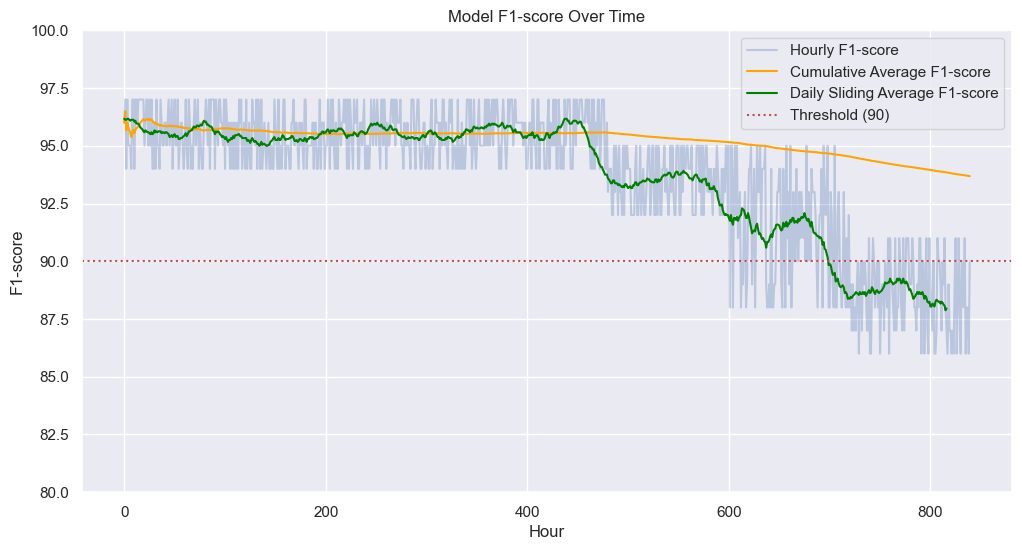

In [9]:
# Plot 

plt.figure(figsize=(12, 6))
plt.plot(hourly_f1, label='Hourly F1-score', alpha=0.3)
plt.plot(hourly_f1_culmulative, label='Cumulative Average F1-score', color='orange')
plt.plot(hourly_f1_daily_sliding, label='Daily Sliding Average F1-score', color='green')
plt.axhline(y=90, color='r', linestyle=':', label='Threshold (90)')
plt.ylim(80, 100)
plt.xlabel('Hour')
plt.ylabel('F1-score')
plt.title('Model F1-score Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Data

In [10]:
import json
import pandas as pd
from urllib.request import urlopen

##### **TODO:**
1. Read the `projects` and `tags` files and join them into a `combined` dataframe.
2. Create a new column called `text` where you will place the `title` and `description` joined with a space character -- `{title} {description}`.
3. Drop the `title` and `description` columns.

In [22]:
project_df = pd.read_csv("data/projects.csv")
tags_df = pd.read_csv("data/tags.csv")

combined_df = pd.merge(project_df, tags_df, left_on='id', right_on='id')
# combined_df.set_index('id', inplace=True)
combined_df["text"] = combined_df["title"] + " " + combined_df["description"]
combined_df.drop(columns=["title", "description"], inplace=True)

In [23]:
print(combined_df["text"][0])   

Comparison between YOLO and RCNN on real world videos Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.


We will use this dataframe as our reference/original data, data that we used to train our ML models. Not to be mistaken with the "real-world" data received in prod

## Univariate

Drift detection on univariate data.


### Kolmogorov-Smirnov (KS) test

KS test for detecting data drift on input sequence length. We can even monitor aspects of our data that aren't necessarily inputs to the model (ex. length of input text).

In [ ]:
!pip install alibi_detect --upgrade
!pip install pyOpenSSL==22.0.0

In [13]:
from alibi_detect.cd import KSDrift

/Users/joshuajustenikiema/Documents/MLOps/Lab5-Docker/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


##### **TODO**:
1. Create a new column that will hold the number of words (e.g., separated by " ") in the `text` column
2. Plot a histogram for the first 200 rows of the newly created column from original dataframe

In [24]:
combined_df["number_words"] = combined_df["text"].apply(lambda x: len(str(x).split()))

In [75]:
ref_data = combined_df["number_words"][:200]

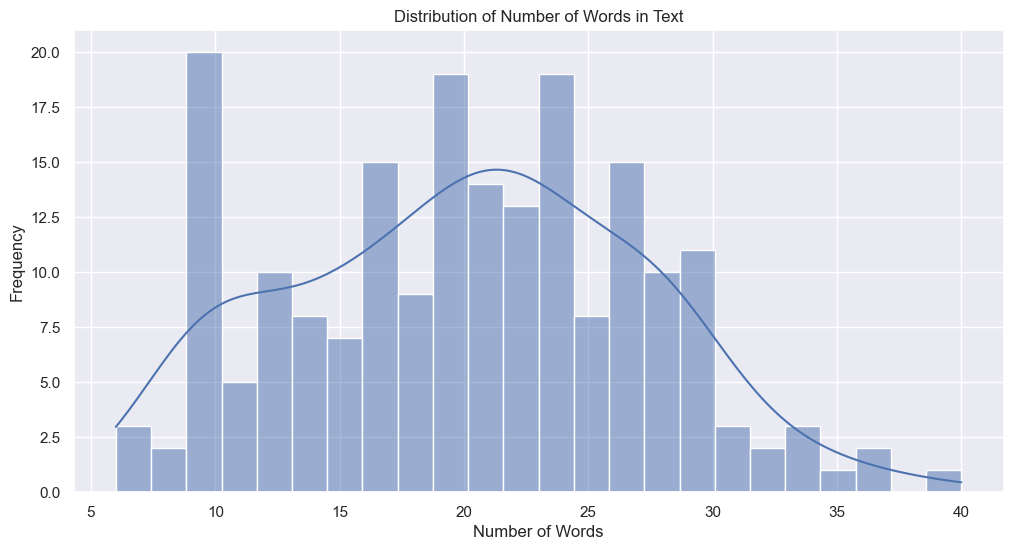

In [71]:
plt.figure(figsize=(12, 6))
sns.histplot(ref_data, bins=24, kde=True)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Words in Text')    
plt.grid(True)
plt.show()

##### **TODO:** Initialize the KSDrift detector on the reference data.

In [ ]:
# Initialize the drift detector with the reference data
cd = KSDrift(ref_data, p_val=0.05)

##### **TODO:**
1. Plot a histogram for the first 200 rows from original dataframe (same as previous task).
2. On top of it, plot a histogram for the next 200 rows (i.e., `[200,400)`) from original dataframe

In [69]:
new_data = combined_df["number_words"][200:400].values

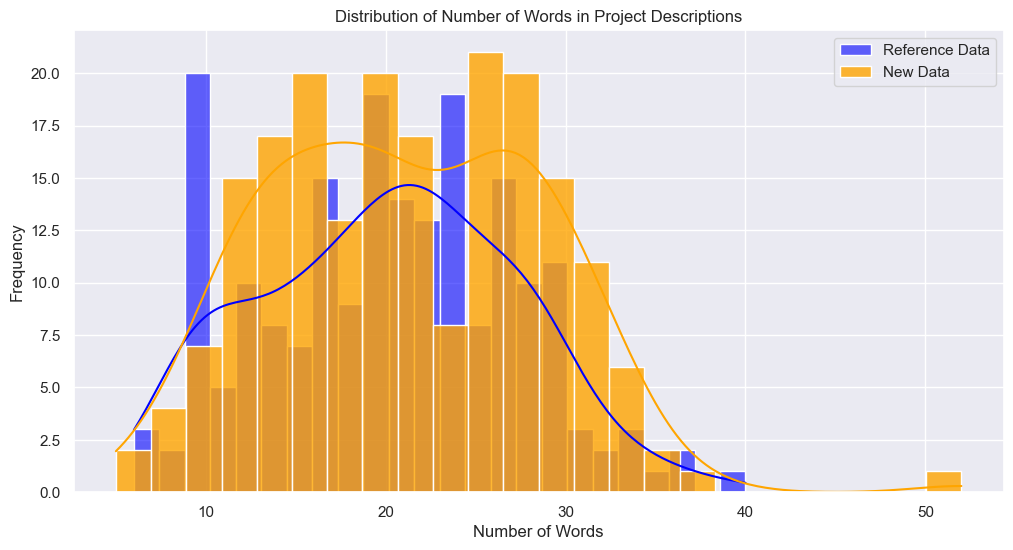

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(ref_data, bins=24, kde=True, color='blue', label='Reference Data', alpha=0.6)
sns.histplot(new_data, bins=24, kde=True, color='orange', label='New Data', alpha=0.8)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Words in Project Descriptions')    
plt.legend()
plt.grid(True)
plt.show() 

##### **TODO:** Apply the drift detector.

In [60]:
pred = cd.predict(combined_df["number_words"][200:400].values)
print(f"Drift detected: {pred['data']['is_drift']} \np-value: {pred['data']['p_val']} \nDistance: {pred['data']['distance']}") 

Drift detected: 0 
p-value: [0.20524779] 
Distance: [0.105]


Given that both dataframes are actually part of the same data, there is no noticeble drift to be detected.

##### **TODO:**
1. Create new data (to represent production data) from a normal distribution with mean=30 and std=5; you can create 200 examples.
2. Plot a hist of this data on top of the hist of the reference data (first 200 rows).

In [63]:
prod_data = np.random.normal(loc=30, scale=5, size=200)

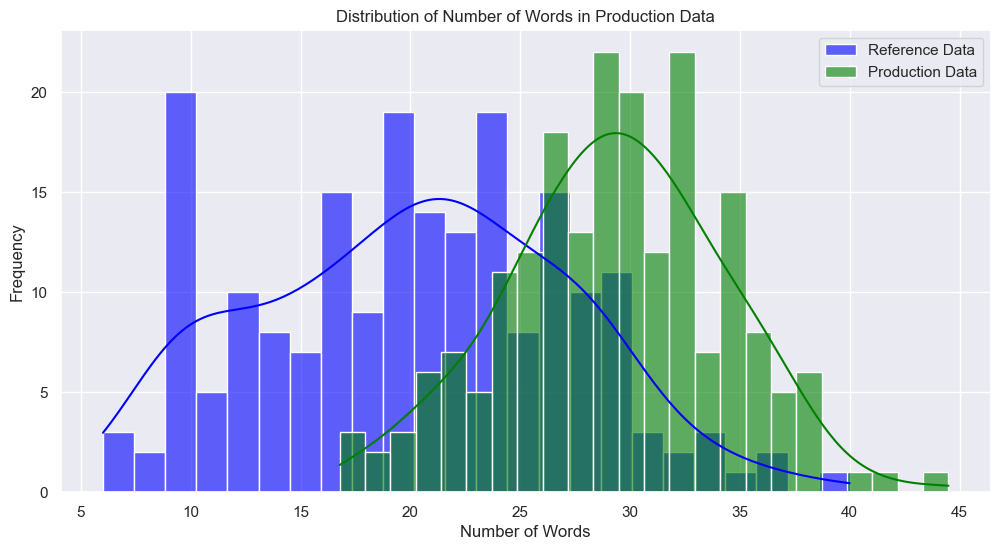

In [64]:
plt.figure(figsize=(12, 6))
sns.histplot(combined_df["number_words"][:200], bins=24, kde=True, color='blue', label='Reference Data', alpha=0.6)
sns.histplot(prod_data, bins=24, kde=True, color='green', label='Production Data', alpha=0.6)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Words in Production Data')    
plt.legend()
plt.grid(True)
plt.show()

##### **TODO:** Apply the drift detector to the reference data and the normal distributed (production) data.

In [65]:
pred = cd.predict(prod_data)
print(f"Drift detected: {pred['data']['is_drift']} \np-value: {pred['data']['p_val']} \nDistance: {pred['data']['distance']}")

Drift detected: 1 
p-value: [4.5636614e-33] 
Distance: [0.585]


### Chi-squared test

Detecting drift on categorical variables (can be used for data or target drift).


In [66]:
from alibi_detect.cd import ChiSquareDrift

##### **TODO:**
1. Add a new column to the reference data called `token_count`. This column should have the value `small` if the `num_tokens` is less or equal than 10; `medium` if in between (10,25] and `large` if larger than 25.
2. Plot the first 200 data of reference data as a histogram.

In [78]:
# 1. Add a new column to the reference data called `token_count`. This column should have the value `small` if the `num_tokens` is less or equal than 10; `medium` if in between (10,25] and `large` if larger than 25.
ref_data["token_count"] = pd.cut(combined_df["number_words"][:200], bins=[-1, 10, 25, float("inf")], labels=["small", "medium", "large"])

In [80]:
ref_data["token_count"]

0       large
1       large
2      medium
3      medium
4      medium
        ...  
195     large
196    medium
197    medium
198    medium
199     large
Name: number_words, Length: 200, dtype: category
Categories (3, object): ['small' < 'medium' < 'large']

##### **TODO:** Initialize the drift detector

##### **TODO:**
1. Take the next 200 data rows from original data, and plot it over the reference data (first 200 rows).
2. Apply the drift detector.

##### **TODO:**
1. Create production data, where you have 80 times `small`, 40 times `medium` and 80 times `large`.
2. Plot the histogram of productions data on top of reference data (first 200 rows).
3. Apply drift detector.